Copyright (c) 2025, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause 

This notebook demonstrates the implementation of a Trotterization time evolution circuit and showcases how to utilize `cuQuantum` experimental `NetworkState` API to simulate a `qiskit.QuantumCircuit` instance.

We evaluate simulation results using the following methods:
  1. MPS with simple update (SU)
  2. MPS with free gauge
  3. TN contraction for exact computation

The notebook is organized into the following sections:

- Creating a Trotterization circuit with qiskit.
- Running the circuit and computing the Pauli-Z expectation values for each qubit using the methods above.
- Evaluating results by comparing the outcomes from these three methods and visualizing them in a figure.

In [1]:
import cupy as cp
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from cuquantum.tensornet.experimental import NetworkState, TNConfig

# Trotterization Circuit

Here, we create a trotterization quantum circuit using Qiskit.

In [2]:
def Hpauli(pauli_ops, n):
    ops = ''
    ids = []
    for idx, pauli in sorted(pauli_ops.items(), reverse=True):
        ops += pauli
        ids.append(idx)
    operator = SparsePauliOp.from_sparse_list([(ops, ids, 1)], num_qubits=n)
    return operator.simplify()
    
def Hz(n):
    op = SparsePauliOp.from_sparse_list([('I', [0], 0)], num_qubits=n)
    for i in range(n):
        op = op + (-1) **(n)/2 * Hpauli({i: 'Z'}, n)
    return op.simplify()
    
def Hyyxx(start_id, n):
    op = SparsePauliOp.from_sparse_list([('I', [0], 0)], num_qubits=n)
    for i in range(start_id, n-1, 2):
        op = op + 1/2 * (Hpauli({i: 'Y', i+1: 'Y'}, n) + Hpauli({i: 'X', i+1: 'X'}, n))
    return (1/2 * op).simplify()
    

def TrotterizedCircuit(nqubits, ntrot, t):
    circ = QuantumCircuit(nqubits)
    for i in range(int(nqubits/2)):
        circ.x(2*i)

    hz = Hz(nqubits)
    hyyxx0 = Hyyxx(0, nqubits)
    hyyxx1 = Hyyxx(1, nqubits)
    for _ in range(ntrot):
        Uz = PauliEvolutionGate(hz, time=(t/2/ntrot))
        circ.append(Uz, range(nqubits))
        Uyyxx0 = PauliEvolutionGate(hyyxx0, time=0.5*(t/ntrot))
        circ.append(Uyyxx0, range(nqubits))
        Uyyxx1 = PauliEvolutionGate(hyyxx1, time=0.3**2*(t/ntrot))
        circ.append(Uyyxx1, range(nqubits))
    
    return circ

# Running the circuit

In this section, we compute the expectation values of the Pauli-Z operator for each qubit in the quantum circuit. The expectation value is given by:

$$
\langle Z_j \rangle = \langle \psi | Z_j | \psi \rangle
$$

where $Z_j$ is the Pauli-Z operator acting on qubit $j$, and $|\psi\rangle$ represents the quantum state prepared by the circuit.

In [3]:
def compute_cuquantum_exp(circ, dtype, backend, config):
    num_qubits = circ.num_qubits
    zvals = []
    with NetworkState.from_circuit(circ, dtype=dtype, backend=backend, config=config) as state:
        for i in range(num_qubits):
            pauli_string = 'I' * i + 'Z' + 'I' * (num_qubits-i-1)
            expec = state.compute_expectation(pauli_string)
            zvals.append(expec.real)
    return cp.asnumpy(cp.array(zvals).flatten())

In [4]:
num_qubits = 12
t = 10
ntrot = 10
bondDim = 6
circ = TrotterizedCircuit(num_qubits, ntrot, t)

## 1. MPS with simple update

In [5]:
# MPS with simple update
dtype = 'complex128'
backend = "cupy"
config_mps_su = {'gauge_option': 'simple', 'abs_cutoff':1e-12, 'max_extent': bondDim}
expec_mps_su = compute_cuquantum_exp(circ, dtype, backend, config_mps_su)
print(f"\n MPS with simple update: {list(expec_mps_su)}")


 MPS with simple update: [-0.23095600261404875, 0.3164881905813822, -0.26383092504388495, 0.2630345631988095, -0.26436402966579514, 0.26433828867395637, -0.26433828867394654, 0.2643640296657893, -0.2630345631987885, 0.26383092504386896, -0.3164881905813928, 0.23095600261405028]


## 2. MPS with free gauge

In [6]:
# MPS with free gauge
config_mps_free = {'gauge_option': 'free', 'abs_cutoff':1e-12, 'max_extent': bondDim}
expec_mps_free = compute_cuquantum_exp(circ, dtype, backend, config_mps_free)
print(f"\n MPS with free gauge: {list(expec_mps_free)}")


 MPS with free gauge: [-0.24603829150079218, 0.330525578929147, -0.2708550612623507, 0.2620476909108522, -0.2550653292373646, 0.25251819445916535, -0.25251819445915885, 0.2550653292373657, -0.26204769091084384, 0.27085506126233916, -0.3305255789291546, 0.24603829150079487]


## 3. TN contraction:

In [7]:
# TN contraction
config_tn = TNConfig(num_hyper_samples=4)
expec_tn = compute_cuquantum_exp(circ, dtype, backend, config_tn)
print(f"\n TN contraction: {list(expec_tn)}")


 TN contraction: [-0.23095771280806163, 0.3164829244918875, -0.26380529892972954, 0.2630133517254252, -0.2643432238649678, 0.2643197619242955, -0.2643197619242956, 0.26434322386496734, -0.2630133517254251, 0.26380529892972976, -0.31648292449188764, 0.23095771280806143]


# Evaluation

Here, we plot the results of three different methods using a bond dimension of 6. The figure demonstrates that with MPS SU, we achieve a significant improvement in accuracy, bringing our results closer to the exact values.

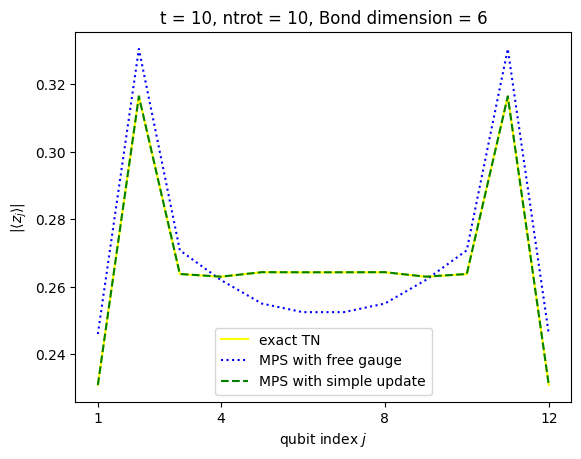

In [8]:
import matplotlib.pyplot as plt

# Example lists
x = range(1, num_qubits+1)

# Plot the data
plt.plot(x, abs(expec_tn), label = 'exact TN', color='yellow')
plt.plot(x, abs(expec_mps_free), label = 'MPS with free gauge', ls=':', color='blue')
plt.plot(x, abs(expec_mps_su), label = 'MPS with simple update', ls = '--', color='green')


# Add labels and title
plt.xlabel('qubit index $j$')
plt.ylabel(r'$|\langle z_j \rangle|$')
plt.title('t = 10, ntrot = 10, Bond dimension = 6')
plt.xticks([1, 4, 8, 12])
plt.legend()
plt.show()